In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client
import gcsfs

In [2]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.scale(8)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.5.241:44617
distributed.scheduler - INFO -   dashboard at:                     :8787


In [3]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-1982d1b4-106e-11ea-8177-5223ed4ec9bd
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.5.241:44617 Dashboard: /user/0000-0002-0703-4786/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
gcs = gcsfs.GCSFileSystem(token = 'anon')

In [5]:
gcs.ls('ivanovich_merra2')

['ivanovich_merra2/t2maxdaily.zarr/']

In [6]:
path = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GSFC/.MERRA2/.Anl_MonoLev/.t2mmax/dods'
temp = xr.open_dataset(path, chunks = {'T': 5})
temp = temp.chunk({'T': 'auto'})

In [6]:
to_map = gcs.get_mapper("ivanovich_merra2/t2maxdaily.zarr/")
ds = xr.open_zarr(to_map)

In [17]:
ds

<xarray.Dataset>
Dimensions:  (T: 14549, X: 576, Y: 361)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
  * X        (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y        (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
Data variables:
    t2mmax   (T, Y, X) float32 dask.array<shape=(14549, 361, 576), chunksize=(160, 361, 576)>
Attributes:
    Conventions:  IRIDL

In [7]:
ds.t2mmax.data

,Array,Chunk
Bytes,12.10 GB,133.08 MB
Shape,"(14549, 361, 576)","(160, 361, 576)"
Count,92 Tasks,91 Chunks
Type,float32,numpy.ndarray


distributed.scheduler - INFO - Register tcp://10.32.15.8:33783
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.15.8:33783
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.4.6:37659
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.6:37659
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.4.7:41833
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.7:41833
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.7.11:34015
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.7.11:34015
distributed.core - INFO - Starting established connection


In [8]:
ds_rechunk = ds.chunk({'T': -1, 'Y': 3})
ds_rechunk.t2mmax.data

,Array,Chunk
Bytes,12.10 GB,100.56 MB
Shape,"(14549, 361, 576)","(14549, 3, 576)"
Count,2360 Tasks,121 Chunks
Type,float32,numpy.ndarray


In [9]:
dsp = ds_rechunk.persist()

## Compute the climatology and anomalies as 2D maps

In [10]:
gb = dsp.groupby("T.dayofyear")
daily_climatology = gb.mean(dim='T')
daily_anomaly = gb - daily_climatology
daily_anomaly

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1311: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:    (T: 14549, X: 576, Y: 361)
Coordinates:
  * Y          (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * X          (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * T          (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
    dayofyear  (T) int64 1 2 3 4 5 6 7 8 9 ... 297 298 299 300 301 302 303 304
Data variables:
    t2mmax     (T, Y, X) float32 dask.array<chunksize=(1, 3, 576), meta=np.ndarray>

In [13]:
dcp = daily_climatology.persist()
dcp

<xarray.Dataset>
Dimensions:    (X: 576, Y: 361, dayofyear: 366)
Coordinates:
  * Y          (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * X          (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    t2mmax     (dayofyear, Y, X) float32 dask.array<chunksize=(1, 3, 576), meta=np.ndarray>

distributed.scheduler - INFO - Register tcp://10.32.16.9:43345
distributed.scheduler - INFO - Register tcp://10.32.6.10:44743
distributed.scheduler - INFO - Register tcp://10.32.6.9:46487
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.16.9:43345
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.6.10:44743
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.6.9:46487
distributed.core - INFO - Starting established connection
distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [12]:
len(daily_climatology.t2mmax.data.dask)

221551

In [23]:
daily_anomaly.mean().load()

KeyboardInterrupt: 

In [9]:

gb_anom = daily_anomaly.groupby("T.dayofyear")
anomaly_std = gb_anom.std(dim = 'T')
print(anomaly_std)

<xarray.Dataset>
Dimensions:    (X: 576, Y: 361, dayofyear: 366)
Coordinates:
  * X          (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y          (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    t2mmax     (dayofyear, Y, X) float32 dask.array<shape=(366, 361, 576), chunksize=(1, 361, 576)>


In [13]:
daily_anomaly.t2mmax.data

,Array,Chunk
Bytes,12.10 GB,831.74 kB
Shape,"(14549, 361, 576)","(1, 361, 576)"
Count,80147 Tasks,14549 Chunks
Type,float32,numpy.ndarray


In [16]:
daily_anomaly.t2mmax.mean(dim='T').load()

KeyboardInterrupt: 

In [9]:
anomaly_std.t2mmax.data

,Array,Chunk
Bytes,304.42 MB,831.74 kB
Shape,"(366, 361, 576)","(1, 361, 576)"
Count,115823 Tasks,366 Chunks
Type,float32,numpy.ndarray


In [11]:
anomaly_std.load()

<xarray.Dataset>
Dimensions:    (X: 576, Y: 361, dayofyear: 366)
Coordinates:
  * X          (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y          (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    t2mmax     (dayofyear, Y, X) float32 2.6119838 2.6119838 ... 4.779266

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gcsfs

In [ ]:
gcs = gcsfs.GCSFileSystem(token='core-dominion-259715-89e814073bdf.json')

In [ ]:
fname = 'ivanovich_merra2/t2mmax_anomaly.zarr'
mapper = gcs.get_mapper(fname)

In [ ]:
with ProgressBar():
    temp.to_zarr(mapper)

## Plot seasonal climatologies

In [12]:
month_gb = ds.groupby("T.month")
monthly_climatology = month_gb.mean(dim='T')

D_clim = monthly_climatology.sel(month = 12)
JF_clim = monthly_climatology.sel(month = slice(1,2))

DJF_clim = xr.concat((D_clim, JF_clim), dim = 'month').mean(dim = 'month')
MAM_clim = monthly_climatology.sel(month = slice(3,5)).mean(dim = 'month')
JJA_clim = monthly_climatology.sel(month = slice(6,8)).mean(dim = 'month')
SON_clim = monthly_climatology.sel(month = slice(9,11)).mean(dim = 'month')

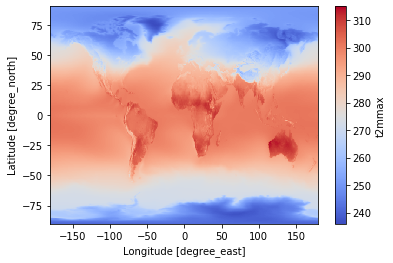

In [13]:
DJF_clim.t2mmax.plot(cmap = 'coolwarm')

## Record Hot/Cold Events

In [ ]:
rolling = daily_anomaly.rolling(T = 2, center = True)
rolling_cold = rolling.min()
rolling_hot = rolling.max()

heat_event = rolling_cold >= 1
cold_event = rolling_hot <= -1

positive_int = heat_event.t2mmax.astype(int)
negative_int = -1 * cold_event.t2mmax.astype(int)
    
plt.plot(positive_int, c = 'r', label = 'Hot Event')
plt.plot(negative_int, c = 'b', label = 'Cold Event')

In [12]:
daily_anomaly

<xarray.Dataset>
Dimensions:    (T: 14549, X: 576, Y: 361)
Coordinates:
  * X          (X) float32 -180.0 -179.375 -178.75 ... 178.125 178.75 179.375
  * Y          (Y) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * T          (T) datetime64[ns] 1980-01-01T12:00:00 ... 2019-10-31T12:00:00
    dayofyear  (T) int64 1 2 3 4 5 6 7 8 9 ... 297 298 299 300 301 302 303 304
Data variables:
    t2mmax     (T, Y, X) float32 dask.array<shape=(14549, 361, 576), chunksize=(1, 361, 576)>

In [ ]:
for i in range(len(anomaly_std.dayofyear)-15):
    if abs(anomaly_std.)
    
    
    I = scipy.integrate.trapz(1/temperature[0:i+1],altitude_m[0:i+1])
    P = pnaught*math.exp((-g/Rd)*I)
    pressure_changingT = np.append(pressure_changingT,P)

In [10]:
range(len(anomaly_std.dayofyear)-15)

range(0, 351)